# PINN Setup: 2 homonuclear atoms

This notebook is for testing and comparing the code for 2 indentical atoms a distance R from the yz axis.

## GPU and Parameter Setup

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import grad

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import time
# import copy

from os import path
import pickle
from scipy.integrate import simps
  
import warnings
warnings.filterwarnings('ignore')

dtype = torch.double    
torch.set_default_tensor_type('torch.DoubleTensor')

lineW = 3
lineBoxW = 2

font = {'size': 11}
matplotlib.rc('font', **font)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams.update({"text.usetex": True})
# plt. close('all')

# Check to see if gpu is available. If it is, use it else use the cpu
if torch.cuda.is_available():
    # device = torch.device('cuda')
    device = torch.device("cuda:0") 
    print('Using ', device, ': ', torch.cuda.get_device_name())   
    # torch.set_default_tensor_type(torch.cuda.FloatTensor)  
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)  
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.DoubleTensor')
    print('No GPU found, using cpu')
    
def set_params():
    params = dict()
    
    boundaries = 18
    params['xL'] = -boundaries; params['xR'] = boundaries
    params['yL'] = -boundaries; params['yR'] = boundaries
    params['zL'] = -boundaries; params['zR'] = boundaries
    params['BCcutoff'] = 17.5

    params['RxL'] = 0.2; params['RxR']= 4
    params['Ry']= 0 ; params['Rz']= 0  
    
    params['cutOff']= 0.005
    params['lossPath'] = "data/loss_atom.pkl" ; 
    params['EnergyPath'] = "data/energy_atom.pkl" ; 
    params['saveModelPath'] = "models/atomsym.pt"
    params['loadModelPath']="models/atomsym.pt"
    params['EnrR_path'] = "data/energy_R_atom.pkl"
       
    params['sc_step'] = 3000; params['sc_decay']=.7 ## WAS 3000
    params['sc_sampling']= 1

    params['n_train'] = 100000; params['n_test'] = 80
    params['epochs'] = int(5e3); #2e3        
    params['lr'] = 8e-3; 
    
    #number of protons in nucleus
    params['Z1'] = 1
    params['Z2'] = 8
    
    #number of orbitals
    params['num_orbitals'] = num_orbitals(params['Z1']) + num_orbitals(params['Z2'])

    
    #Select which LCAO solution to use
    params['c_i'] = 0

    params['inversion_symmetry'] = 1  
    
    return params

Using  cuda:0 :  NVIDIA GeForce RTX 3060 Ti


## Activation functions

In [2]:
class toR(torch.nn.Module):
    @staticmethod
    def forward(input):
        r2 = input[:,0].pow(2) + input[:,1].pow(2) + input[:,2].pow(2)
        r = torch.sqrt(r2) 
        r = r.reshape(-1,1)
        return r

class toTheta(torch.nn.Module):
    @staticmethod
    def forward(input):
        r2 = input[:,0].pow(2) + input[:,1].pow(2) + input[:,2].pow(2)
        r = torch.sqrt(r2)
        theta = torch.arccos(input[:,2]/r)
        theta = theta.reshape(-1,1)
        return theta
    
class toPhi(torch.nn.Module):
    @staticmethod
    def forward(input):
        #torch.sgn(input[:,1])*
        phi = torch.arccos(input[:,0]/torch.sqrt(torch.pow(input[:,0],2)+torch.pow(input[:,1],2)))
        phi = phi.reshape(-1,1)
        return phi

def orbital(r,theta,phi,Z,orbital_name):
    """
    Inputs r,theta,phi polar co-ords.
    With atom located at centre.
    Returns the orbital shape given the orbital name.
    """
    
    if orbital_name == '1s':
        chi = Z**(3/2)*torch.exp(-r*Z)
    elif orbital_name == '2s':
        chi = Z**(3/2)*(2-(r*Z))*torch.exp(-r*Z/2)
    elif orbital_name == '2pz':
        chi = Z**(3/2)*(r*Z)*torch.exp(-r*Z/2)*torch.cos(theta)
    elif orbital_name == '2py' or orbital_name == '2px':
        chi = Z**(3/2)*(r*Z)*torch.exp(-r*Z/2)*torch.sin(theta)
        if orbital_name == '2px':
            chi = chi.mul(torch.exp(phi*1j))
        else:
            chi = chi.mul(torch.exp(-1*phi*1j))
    elif orbital_name == '3s':
        chi = Z**(3/2)*(27-18*(r*Z)+2*torch.pow(r*Z,2))*torch.exp(-r*Z/3)
    elif orbital_name == '3pz':
        chi = Z**(3/2)*(6*r-torch.pow(r*Z,2))*torch.exp(-r*Z/3)*torch.cos(theta)
    elif orbital_name == '3py' or orbital_name == '3px':
        chi = Z**(3/2)*(6*r-torch.pow(r*Z,2))*torch.exp(-r*Z/3)*torch.sin(theta)
        if orbital_name == '3px':
            chi = chi.mul(torch.exp(phi*1j))
        else:
            chi = chi.mul(torch.exp(-1*phi*1j))
    elif orbital_name == '4s':
        chi = Z**(3/2)*(Z*r-1)*((Z*r)**2*-8*(Z*r)+12)*torch.exp(-Z*r)
    elif orbital_name == '3dz2':
        chi = Z**(3/2)*torch.pow(r*Z,2)*torch.exp(-r*Z/3)*(3*torch.cos(theta)**2-1)
    elif orbital_name == '3dyz' or orbital_name == '3dxz':
        chi = Z**(3/2)*torch.pow(r*Z,2)*torch.exp(-r*Z/3)*torch.sin(theta)*torch.cos(theta)
        if orbital_name == '3dxz':
            chi = chi.mul(torch.exp(phi*1j))
        else: 
            chi = chi.mul(torch.exp(-1*phi*1j))
    elif orbital_name == '3dxy' or orbital_name == '3dx2y2':
        chi = Z**(3/2)*torch.pow(r*Z,2)*torch.exp(-r*Z/3)*torch.sin(theta)**2
        if orbital_name == '3dx2y2':
            chi = chi.mul(torch.exp(phi*1j))
        else: 
            chi = chi.mul(torch.exp(-1*phi*1j))
    else:
        raise ValueError("orbital_name invalid. A value of {} was entered. Allowed inputs:".format(orbital_name)+
                         "'1s', '2s', '2px', '2py, '2pz', '3s', '3px', '3py', '3pz', '3dz2', '3dyz', '3dxz', '3dxy', '3dx2y2', '4s'.")
    chi = chi.reshape(-1,1)

    return chi

class atomicAct(torch.nn.Module):
    @staticmethod
    def forward(polarVec,Z):
        """
        Input vector in polar co-ordinates.
        Sums together the different atomic orbitals for the atom.
        Returns atomic orbitals for atom.
        """
        AO_sum = torch.zeros(len(polarVec))
        AO_sum = AO_sum.reshape(-1,1)
        
        #fill Z electron orbitals
        #Only works up to Z=30 currently
        #returns nan values for 2px, 2py, 3px, 3py, 3dyz, 3dxz, 3dxy, 3dx2y2
        if Z > 0: 

            #1s
            orbArray = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='1s')
            AO_sum = AO_sum.add(orbArray)
                
        if Z >= 3:
            #2s
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='2s')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
        if Z >= 5:
            #2pz
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='2pz')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #2px
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='2px')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #2py
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='2py')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
        if Z >= 11:
            #3s
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3s')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
        if Z >= 13:
            #3pz
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3pz')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #3px
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3px')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #3py
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3py')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
        if Z >= 19:
            #4s
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='4s')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
        if Z >= 21:
            #3dz2
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3dz2')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #3dyz
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3dyz')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #3dxz
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3dxz')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #3dxy
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3dxy')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
            
            #3dx2y2
            orb = orbital(polarVec[:,0],polarVec[:,1],polarVec[:,2],Z,orbital_name='3dx2y2')
            AO_sum = AO_sum.add(orb)
            orbArray = torch.cat((orbArray,orb),1)
        
        return  AO_sum, orbArray

## Differential Operators

In [3]:
def dfx(x,f):
    """
    Returns 1st derivative
    """
    return grad([f],[x],grad_outputs=torch.ones(x.shape,dtype=dtype),create_graph=True)[0]

def d2fx(x,f):
    """
    Returns 2nd derivative
    """
    return grad(dfx(x,f),[x],grad_outputs=torch.ones(x.shape,dtype=dtype),create_graph=True)[0]

def lapl(x,y,z,f):
    """
    Returns value of the laplacian operator at x,y,z for function f
    """

    f_xx, f_yy, f_zz = d2fx(x,f), d2fx(y,f), d2fx(z,f)
    return f_xx + f_yy + f_zz

## Physical and Misc. Functions

In [4]:
def num_orbitals(Z):
    #calcualtes the number of orbitals present
    if Z >= 1 and Z < 3:
        num_AO = 1
    if Z >= 3 and Z < 5:
        num_AO = 2
    if Z >= 5 and Z < 11:
        num_AO = 5
    if Z >= 11 and Z < 13:
        num_AO = 6
    if Z >= 13 and Z < 19:
        num_AO = 9
    if Z >= 19 and Z < 21:
        num_AO = 10
    if Z >= 21 and Z < 31:
        num_AO = 15
    if Z >= 31 and Z < 37:
        num_AO = 18
    if Z >= 37:
        raise ValueError("Input atomic number {} too large.".format(Z))
        
    return num_AO

def radial(x,y,z,R,params):
    """
    Returns the radial part from cartesian coordinates
    """
    Rx = R
    Ry = params['Ry']
    Rz = params['Rz']
    r1 = torch.sqrt((x-Rx).pow(2)+(y-Ry).pow(2)+(z-Rz).pow(2))
    r2 = torch.sqrt((x+Rx).pow(2)+(y+Ry).pow(2)+(z+Rz).pow(2))
    
    return r1, r2

def V(x,y,z,R,params):
    """
    Potential energy function.
    For each electron calculate coulomb potential from all other electrons
    """
    #positions of each atom
    r1,r2 = radial(x,y,z,R,params)
    
    #effective nuclear charge
    eff_charge = {1:1, 2:1.688, 3:1.279, 4:1.912, 5:2.421, 6:3.136, 7:3.834, 8:4.453, 9:5.1, 10:5.758,
                  11:2.507, 12:3.308, 13:4.066, 14:4.285, 15:4.886, 16:5.482, 17:6.116, 18:6.764, 19:3.495, 20:4.398,
                  21:7.12, 22:8.141, 23:8.983, 24:9.757, 25:10.582, 26:11.18, 27:11.855, 28:12.53, 29:13.201, 30:13.878}
    
    Z1_eff = eff_charge[params['Z1']]
    Z2_eff = eff_charge[params['Z2']]
    
    potential = -Z1_eff/r1 -Z2_eff/r2
    
    return potential
    
def hamiltonian(x,y,z,R,psi,params):
    """
    Returns Hamiltonian for this setup
    """
    laplacian = lapl(x,y,z,psi)
    return  -0.5*laplacian + V(x,y,z,R,params)*psi

def calculate_LCAO_constants(x,y,z,R,orbArray):
    """
    Determine H_matrix which is NxN matrix where each entry H_ij is <chi_i|H|chi_j>
    Determine S_matrix where each entry is <chi_i|chi_j>
    Solve S^-1*H*c = E*c eigen equation
    Return values of c and E
    """
    #calculate H and S
    n_orbitals = orbArray.shape[1]
    H = torch.zeros((n_orbitals,n_orbitals))
    S = torch.zeros((n_orbitals,n_orbitals))
    
    for i in range(0,n_orbitals):
        for j in range(i+1):
            #print(i,j)
            
            #H|chi_j>
            H_chi = hamiltonian(x,y,z,R,orbArray[:,j].reshape(-1,1).real,params)
            
            #<chi_i|H|chi_j>
            H[i,j] = torch.matmul(orbArray[:,i].real,H_chi)
            H[j,i] = H[i,j]
            
            S[i,j] = torch.matmul(orbArray[:,i].real,orbArray[:,j].reshape(-1,1).real)
            S[i,j] = S[j,i]
    
    #Solve eigen equation
    #print(H)
    #print(S)
    S_inv = torch.linalg.inv(S)
    S_inv_H = torch.matmul(S_inv,H)
    
    #use torch.linalg.eig(MATRIX=S^-1H)
    E, c = torch.linalg.eig(S_inv_H)
    return E, c
        
## Misc helper functions 

def sampling(params, n_points, linearSampling=False):
    # Sampling from a 4d space: 3d variable (x,y,z) and 1d parameter (R) space
    xR = params['xR']; xL = params['xL']; yR = params['yR'];
    yL = params['yL']; zR = params['zR']; zL = params['zL']; 
    cutOff = params['cutOff']
    
    if linearSampling == True:
        x = torch.linspace(xL,xR,n_points,requires_grad=False)
        y = torch.linspace(yL,yR,n_points,requires_grad=False)
        z = torch.linspace(zL,zR,n_points,requires_grad=False)
        R = torch.linspace(params['RxL'],params['RxR'],n_points,requires_grad=False)
    else: 
        x = (xL - xR) * torch.rand(n_points,1) + xR
        y = (yL - yR) * torch.rand(n_points,1) + yR
        z = (zL - zR) * torch.rand(n_points,1) + zR
        R = (params['RxL'] - params['RxR'])* torch.rand(n_points,1) + params['RxR']
        
    #r1,r2 = radial(x,y,z,R,params)
    #x[r1<cutOff] = cutOff
    #x[r2<cutOff] = cutOff
    x,y,z = x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1); R=R.reshape(-1,1)        
    x.requires_grad=True; y.requires_grad=True; z.requires_grad=True; R.requires_grad=True     
    return x,y,z,R

def saveLoss(params,lossDictionary):
    with open(params['lossPath'], 'wb') as f:
        pickle.dump(lossDictionary, f)
        
def returnGate():
    modelTest = NN_atom(params);     modelTest.loadModel(params)   
    R = torch.linspace(params['RxL'],params['RxR'],params['n_train'], requires_grad=False)
    R = R.reshape(-1,1)
    R.requires_grad=True
    f = modelTest.netDecayL(R)
    f = modelTest.sig(f)
    f = modelTest.netDecay(f) 
    return R.cpu().detach().numpy(), f.cpu().detach().numpy()

def integra3d(x,y,z,f):   
    # 3d integration using Simpson method of scipy
    f = f.detach().numpy()
    x = x.detach().numpy()
    y = y.detach().numpy()
    z = z.detach().numpy()
    I = simps( [simps( [simps(fx, x) for fx in fy], y) for fy in f ]  ,z)
    return I

### Plot

In [5]:
def plotLoss(params,saveFig=True):
    with open(params['lossPath'], 'rb') as f:
        loaded_dict = pickle.load(f)

    plt.figure(figsize=[19,8])
    plt.subplot(1,2,1)
    plt.plot(loaded_dict['Ltot'],label='total',linewidth=lineW*2)
    plt.plot(loaded_dict['Lpde'],label='pde',linewidth=lineW)    
    plt.plot(loaded_dict['Lbc'] ,label='bc',linewidth=lineW)
    plt.ylabel('Loss'); plt.xlabel('epochs')
    plt.axvline(params['epochs'], c='r', linestyle='--', linewidth=lineW*1.5, alpha=0.7)
    plt.yscale('log')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loaded_dict['Energy'],'-k',linewidth=lineW)
    plt.ylabel('Energy'); plt.xlabel('epochs')
    plt.axvline(params['epochs'], c='r', linestyle='--', linewidth=lineW*1.5, alpha=0.7)
    plt.tight_layout()
    
    if saveFig==True:
        plt.savefig('figures/atom_figure.jpg', format='jpg')

## Neural Network Architecture

In [6]:
class NN_atom(nn.Module):
    def __init__(self,params,dense_neurons=16,dense_neurons_E=32,netDecay_neurons=10): 
        super(NN_atom,self).__init__()

        self.sig =  nn.Sigmoid()          
        self.toR = toR()
        self.toTheta = toTheta()
        self.toPhi = toPhi()
        self.actAO = atomicAct()  
        self.Lin_H1 = torch.nn.Linear(params['num_orbitals'], dense_neurons) 
        self.Lin_H2 = torch.nn.Linear(dense_neurons, dense_neurons, bias=True) 
        
        self.Lin_out = torch.nn.Linear(dense_neurons, 1)                
        
        self.Lin_E1 = torch.nn.Linear(1, dense_neurons_E) 
        self.Lin_E2 = torch.nn.Linear(dense_neurons_E, dense_neurons_E) 

        self.Lin_Eout = torch.nn.Linear(dense_neurons_E, 1)                
        nn.init.constant_(self.Lin_Eout.bias[0], -1) 

        self.Ry = params['Ry'] 
        self.Rz = params['Rz']
        self.Z1 = params['Z1']
        self.Z2 = params['Z2']
        self.c_i = params['c_i']
        self.P = params['inversion_symmetry']
        self.netDecayL = torch.nn.Linear(1, netDecay_neurons, bias=True)  
        self.netDecay = torch.nn.Linear(netDecay_neurons, 1, bias=True)  

    def forward(self,x,y,z,R,c):        
        ## ENERGY PARAMETER
        e = self.Lin_E1(R) 
        e = self.sig(e)
        e = self.Lin_E2(e) 
        e = self.sig(e)
        E = self.Lin_Eout(e)
        
        ## ATOMIC Layer: Radial part, orbitals based on radial and physics-based activation
        fi_r1,  fi_r2, orbArray = self.atomicUnit(x,y,z,R)        
        fi_r1m, fi_r2m, orbArraym = self.atomicUnit(-x,y,z,R)  
        
        ## LCAO SOLUTION
        N_LCAO = self.lcao_solution(x,y,z,R,orbArray,c)
        
        ## NONLINEAR HIDDEN LAYERS        
        B  = self.base(orbArray) + self.P*self.base(orbArraym)
        NN = self.Lin_out(B)
    
        f = self.netDecayL(R)
        f = self.sig(f)
        f = self.netDecay(f) 
        NN = NN*f
        
        Nout = NN + N_LCAO      
        return Nout, E, orbArray
 
    def atomicUnit(self,x,y,z,R):
        """
        Takes the 2 inputs r and R.
        Returns the hydrogen atomic s-orbitals for each ion.
        """
        # Cartesian Translation & Scaling: 
        x1 = x - R
        y1 = y - self.Ry 
        z1 = z - self.Rz        
        rVec1 = torch.cat((x1,y1,z1),1)
        
        #parameters for orbital
        r1 = self.toR(rVec1)
        theta1 = self.toTheta(rVec1)
        phi1 = self.toPhi(rVec1)
        polarVec1 = torch.cat((r1,theta1,phi1),1)
        
        # ATOMIC ORBITAL ACTIVATION
        fi_r1, orbArray1 = self.actAO(polarVec1,self.Z1) 

        # -- 
        x2 = x + R; 
        y2 = y + self.Ry; z2 = z + self.Rz        
        rVec2 = torch.cat((x2,y2,z2),1)
        
        r2 = self.toR(rVec2)         
        theta2 = self.toTheta(rVec2)
        phi2 = self.toPhi(rVec2)
        polarVec2 = torch.cat((r2,theta2,phi2),1)
        
        fi_r2, orbArray2 = self.actAO(polarVec2,self.Z2)
        
        orbArray = torch.cat((orbArray1,orbArray2),1)
        
        #Check for nan values
        for i in range(len(phi1)):
            if torch.isnan(phi1[i]) == True or torch.isnan(phi2[i]):
                print(i)
                print('phi1 value:',phi1[i])
                print('phi2 value:',phi2[i])
        
        return fi_r1, fi_r2, orbArray
    
    def lcao_solution(self,x,y,z,R,orbArray,c):
        """
        Calculate the LCAO solution for the atomic orbitals given in orbArray.
        Uses specified value of c which refers to the relevant molecular orbital.
        Return LCAO solution for selected molecular orbital.
        """
        #Now perform linear sum
        n_orbitals = orbArray.shape[1]
        lcao = torch.mul(c[0],orbArray[:,0].reshape(-1,1))
        for i in range(1,n_orbitals):
            lcao = torch.add(lcao,torch.mul(c[i],orbArray[:,i].reshape(-1,1)))    
        
        return lcao
    
    def base(self,orbArray):
        """
        NONLINEAR HIDDEN LAYERS; Black box
        """
        #take only the real part of atomic units
        orbArray = orbArray.real
        
        orbArray = self.Lin_H1(orbArray)         
        orbArray = self.sig(orbArray) 
        orbArray = self.Lin_H2(orbArray)         
        orbArray = self.sig(orbArray) 
        
        #orbArray = self.Lin_H3(orbArray);         orbArray = self.sig(orbArray) 
        
        return orbArray
        
    def freezeBase(self):
        #for p in self.parameters():
        #p.requires_grad=False
        self.Lin_H1.weight.requires_grad=False
        self.Lin_H1.bias.requires_grad=False
        self.Lin_H2.weight.requires_grad=False
        self.Lin_H2.bias.requires_grad=False    
        self.Lin_out.weight.requires_grad=False
        self.Lin_out.bias.requires_grad=False
        
    def freezeDecayUnit(self):
        self.netDecayL.weight.requires_grad=False
        self.netDecayL.bias.requires_grad=False
        self.netDecay.weight.requires_grad=False
        self.netDecay.bias.requires_grad=False
        
    def parametricPsi(self,x,y,z,R,c):
        N, E, orbArray = self.forward(x,y,z,R,c) 
        return  N, E, orbArray
   
    def loadModel(self,params):
        checkpoint = torch.load(params['loadModelPath'])
        self.load_state_dict(checkpoint['model_state_dict'])
        self.eval(); 

    def saveModel(self,params,optimizer):
        torch.save({
            # 'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'loss': loss
        },  params['saveModelPath'])   
        
    def LossFunctions(self,x,y,z,R,params,bIndex1,bIndex2,c):
        lam_bc, lam_pde = 1 , 1    #lam_tr = 1e-9
        psi, E, orbArray = self.parametricPsi(x,y,z,R,c)
        #--# PDE       
        psi = psi.real
        psi = psi.to(torch.float64)     
        res = hamiltonian(x,y,z,R,psi,params) - E*psi                
        LossPDE = (res.pow(2)).mean() * lam_pde
        Ltot = LossPDE         
        #--# BC
        Lbc =  lam_bc *( (psi[bIndex1].pow(2)).mean() 
               + (psi[bIndex2].pow(2)).mean() )

        Ltot = LossPDE + Lbc
        # 
        #--# Trivial
        # Ltriv = 1/(psi.pow(2)).mean()* lam_tr ;    Ltot = Ltot + Ltriv 
        return Ltot, LossPDE, Lbc, E

## Training Function

In [7]:
def train(params,loadWeights=False,freezeUnits=False,optimiser='Adam'):
    lr = params['lr'] 
    model = NN_atom(params)     # modelBest=copy.deepcopy(model)
    
    if optimiser == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
        print('Train with Adam')   
    elif optimiser == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)
        print('Train with SGD')
    
    print('Setup is 2 atoms with atomic numbers {} and {}.'.format(params['Z1'],params['Z2']))
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=params['sc_step'],gamma=params['sc_decay'])    
    Llim =  10 ; optEpoch=0    

    epochs = params['epochs'] # For Adam 
    total_epochs = epochs
    # total_epochs = params['epochs_LB'] + epochs
    Ltot_h = np.zeros([total_epochs,1]); Lpde_h = np.zeros([total_epochs,1])
    Lbc_h= np.zeros([total_epochs,1]);   E_h = np.zeros([total_epochs,1])
    # Ltr_h = np.zeros([total_epochs,1]); Linv_h= np.zeros([total_epochs,1])
    
    ## LOADING pre-trained model if PATH file exists and loadWeights=True
    if path.exists(params['loadModelPath']) and loadWeights == True:
        print('loading model')
        model.loadModel(params) 

    if  freezeUnits==True:
        print('Freezeing Basis unit and Gate')
        model.freezeDecayUnit()
        model.freezeBase()
        
    TeP0 = time.time() # for counting the training time
    print(time.strftime("%Y-%m-%d %H:%M:%S",time.gmtime()))
        
    n_points = params['n_train'] # the training batch size
    
    #Sample Inputs
    x,y,z,R = sampling(params,n_points,linearSampling=False)
    
    #r1,r2 = radial(x, y, z,R, params)
    #bIndex1 = torch.where(r1 >= params['BCcutoff'])
    #bIndex2 = torch.where(r2 >= params['BCcutoff'])
    
    #####--------------------------------------------------------------------    
    ############### TRAINING LOOP ########################    
    #####--------------------------------------------------------------------
    for tt in range(epochs):        
        optimizer.zero_grad()
        
        if tt == 0:
            #calc c?
            _, _, orbArray = model.atomicUnit(x,y,z,R)
            E, c = calculate_LCAO_constants(x,y,z,R,orbArray)
            print('Min energy:',torch.min(E.real),torch.argmin(E.real))
            c = c[:,torch.argmin(E.real)]
            #c = c[:,params['c_i']]
            c = c.reshape((-1,1))
            c = c.detach()
        
        if tt % params['sc_sampling'] == 0 and tt < 0.9*epochs:
            x,y,z,R = sampling(params, n_points, linearSampling=False)            
            r1,r2 = radial(x,y,z,R,params)
            bIndex1 = torch.where(r1 >= params['BCcutoff'])
            bIndex2 = torch.where(r2 >= params['BCcutoff'])        
        
        Ltot, LossPDE, Lbc, E = model.LossFunctions(x,y,z,R,params,bIndex1,bIndex2,c)
        
        Ltot.backward(retain_graph=False); optimizer.step(); 
        # if  tt < 2001:
        #     scheduler.step()
        
        if (tt+1)%100 == 0:
            print(f'epoch {tt+1}/{epochs}')
            if (tt+1) == 100:
                compute_time = (time.time()-TeP0)*(params['epochs']/100)
                print('Estimate compute time (mins): {}'.format(compute_time/60))

        # keep history           
        Ltot_h[tt] = Ltot.cpu().data.numpy();  Lpde_h[tt] = LossPDE.cpu().data.numpy()
        Lbc_h[tt] = Lbc.cpu().data.numpy();  E_h[tt] = E[-1].cpu().data.numpy()
        # Ltr_h[tt]  = Ltriv.data.numpy();  
        
        #    Keep the best model (lowest loss). Checking after 50% of the total epochs 
        if  tt > 0.5*epochs  and Ltot < Llim:
            Llim=Ltot
            model.saveModel(params, optimizer)
            optEpoch = tt
            
    print('Optimal epoch: ', optEpoch)

    #####--------------------------------------------------------------------
    ##### END TRAINING
    #####--------------------------------------------------------------------
    TePf = time.time();    runTime = TePf - TeP0        

    lossDictionary = {'Ltot':  Ltot_h,  'Lbc': Lbc_h, 'Lpde':Lpde_h, 'Energy': E_h }
    saveLoss(params, lossDictionary)

    print('Runtime (min): ', runTime/60)    
    print('last learning rate: ', scheduler.get_last_lr())
    # return E,R

## Check results for H2

In [8]:
params = set_params()

params['epochs'] = int(5e3) 
nEpoch1 = params['epochs']
params['n_train'] = 10000
params['lr'] = 8e-3
params['Z1'] = 1
params['Z2'] = 1
params['num_orbitals'] = num_orbitals(params['Z1']) + num_orbitals(params['Z2'])
params['c_i'] = 0

params['lossPath'] = "data/loss_H2.pkl"
params['EnergyPath'] = "data/energy_H2.pkl" 
params['saveModelPath'] = "models/atoms_H2.pt"
params['loadModelPath'] = "models/atoms_H2.pt"
params['EnrR_path'] = "data/energy_R_H2.pkl"

2023-08-26 19:13:16
Train with Adam
Setup is 2 atoms with atomic numbers 1 and 1.
epoch 100/5000
Estimate compute time (mins): 160.92283328374228
epoch 200/5000
epoch 300/5000
epoch 400/5000
epoch 500/5000
epoch 600/5000
epoch 700/5000
epoch 800/5000
epoch 900/5000
epoch 1000/5000
epoch 1100/5000
epoch 1200/5000
epoch 1300/5000
epoch 1400/5000
epoch 1500/5000
epoch 1600/5000
epoch 1700/5000
epoch 1800/5000
epoch 1900/5000
epoch 2000/5000
epoch 2100/5000
epoch 2200/5000
epoch 2300/5000
epoch 2400/5000
epoch 2500/5000
epoch 2600/5000
epoch 2700/5000
epoch 2800/5000
epoch 2900/5000
epoch 3000/5000
epoch 3100/5000
epoch 3200/5000
epoch 3300/5000
epoch 3400/5000
epoch 3500/5000
epoch 3600/5000
epoch 3700/5000
epoch 3800/5000
epoch 3900/5000
epoch 4000/5000
epoch 4100/5000
epoch 4200/5000
epoch 4300/5000
epoch 4400/5000
epoch 4500/5000
epoch 4600/5000
epoch 4700/5000
epoch 4800/5000
epoch 4900/5000
epoch 5000/5000
Optimal epoch:  4348
Runtime (min):  158.43192565043768
last learning rate:  [

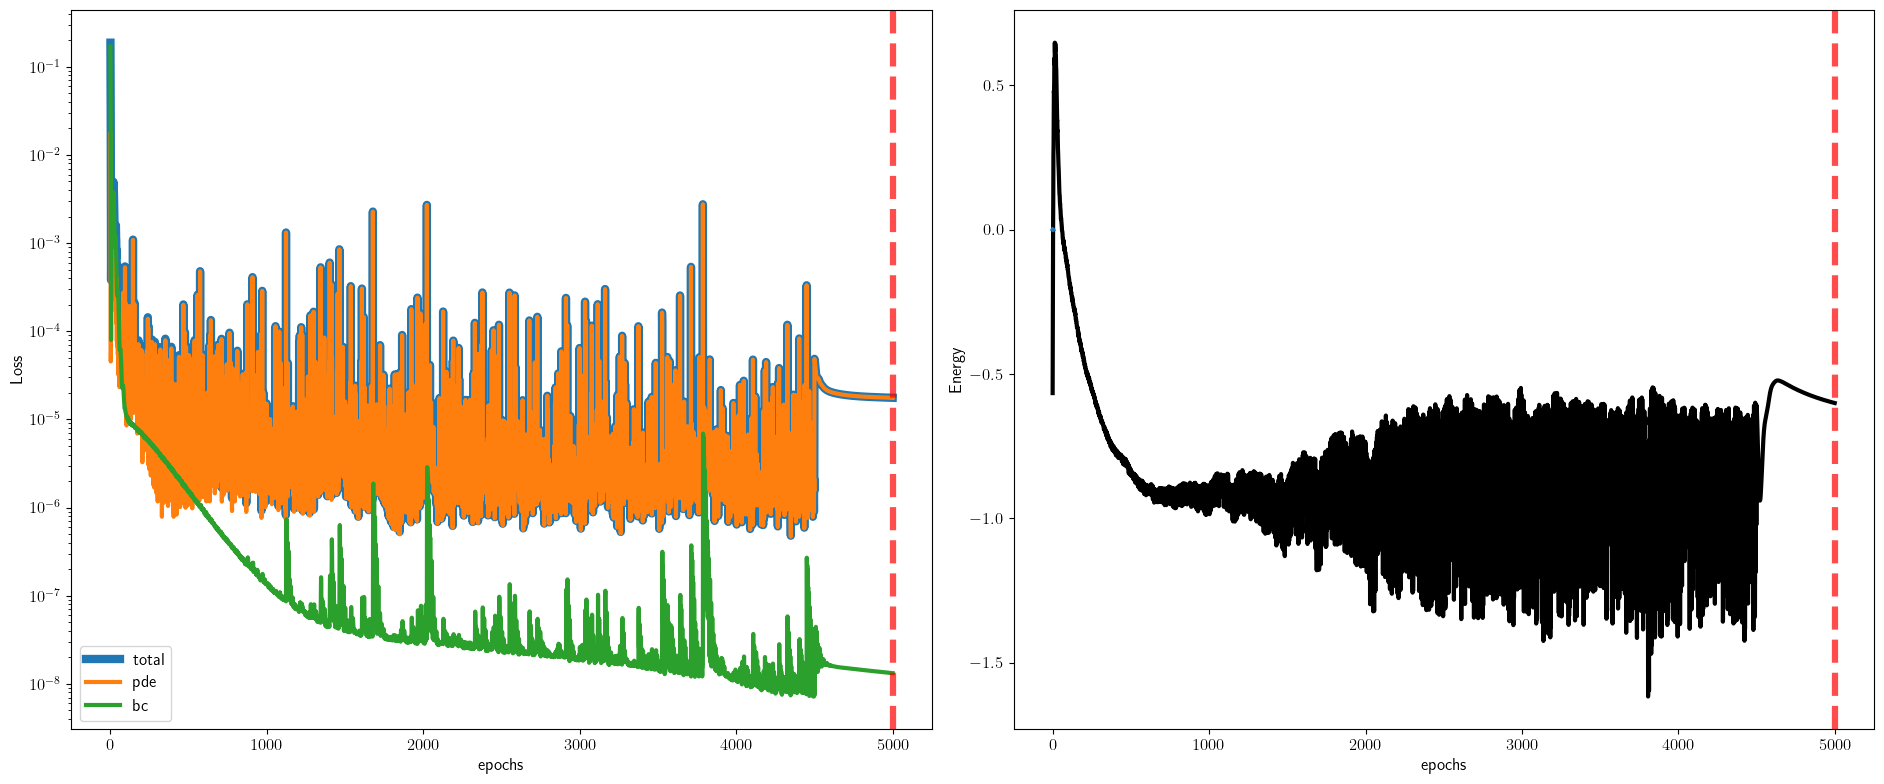

In [25]:
model = NN_atom(params)

#### ----- Training: Single model ------------
train(params,loadWeights=False)

plotLoss(params,saveFig=False)

Rg, gate = returnGate()
plt.plot(Rg, gate, linewidth=lineW)

Train with Adam
Setup is 2 atoms with atomic numbers 1 and 1.
loading model
Freezeing Basis unit and Gate
epoch 100/2000
Estimate compute time (mins): 61.831957499186196
epoch 200/2000
epoch 300/2000
epoch 400/2000
epoch 500/2000
epoch 600/2000
epoch 700/2000
epoch 800/2000
epoch 900/2000
epoch 1000/2000
epoch 1100/2000
epoch 1200/2000
epoch 1300/2000
epoch 1400/2000
epoch 1500/2000
epoch 1600/2000
epoch 1700/2000
epoch 1800/2000
epoch 1900/2000
epoch 2000/2000
Optimal epoch:  1087
Runtime (min):  59.797127441565195
last learning rate:  [0.0005]


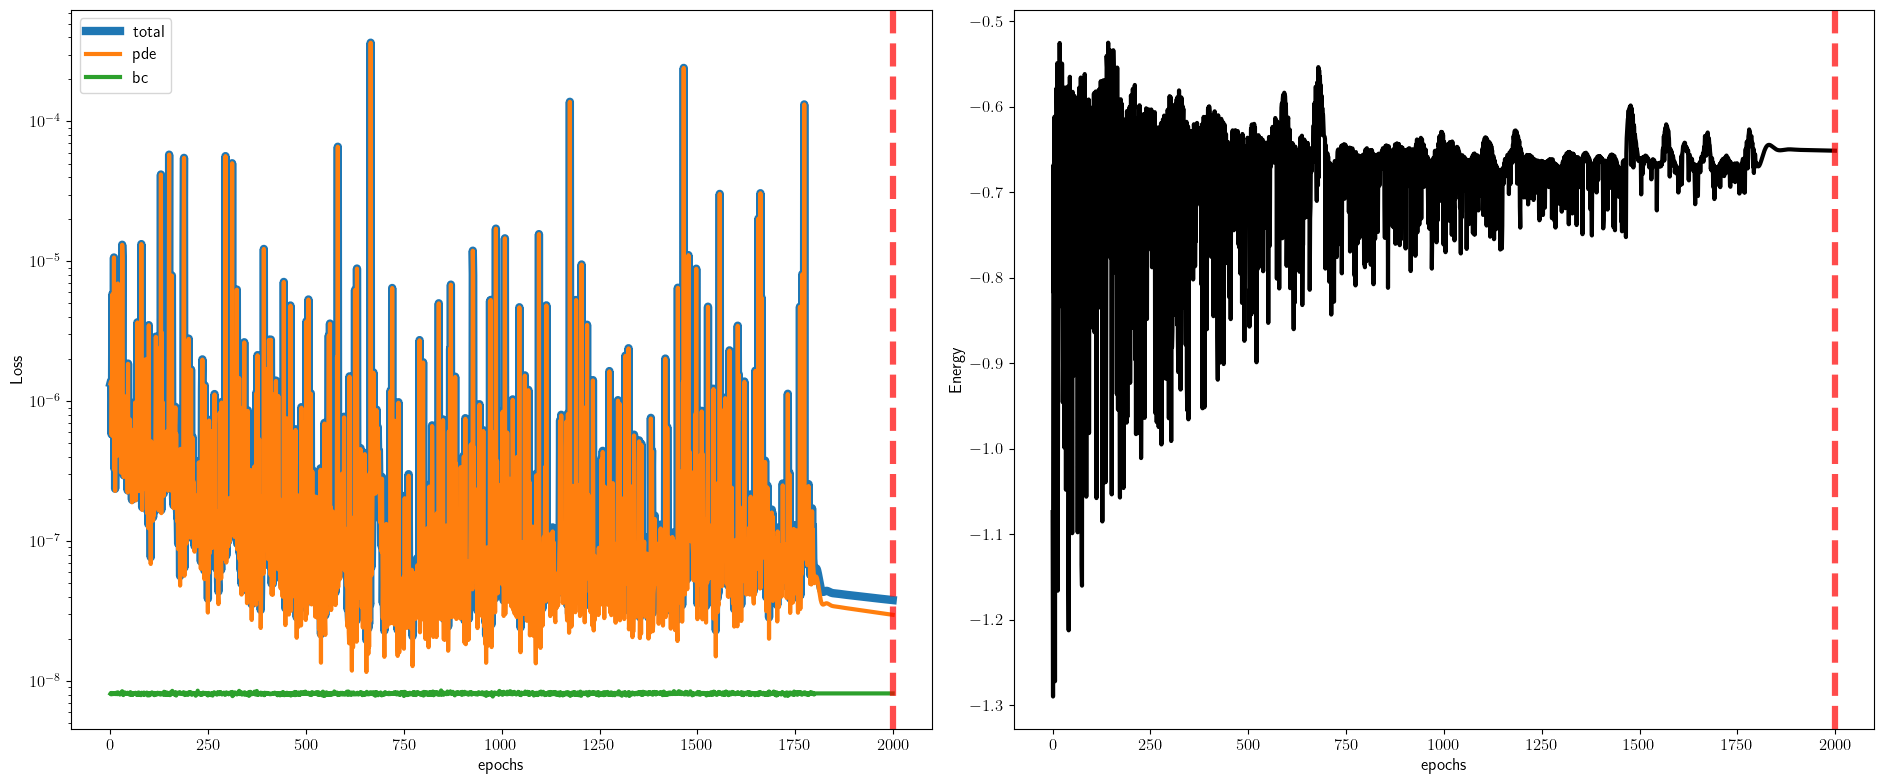

In [27]:
#### ----- Fine Tuning ----------

# params=set_params()
params['loadModelPath'] = "models/atoms_H2.pt"
params['lossPath'] = "data/loss_H2_fineTune.pkl"
params['EnergyPath'] = "data/energy_H2_fineTune.pkl" ; 
params['saveModelPath'] ="models/H2_fineTune.pt"

# params['sc_step'] = 10000; params['sc_decay']=.7
params['sc_sampling'] = 1

params['epochs'] = int(2e3)
nEpoch2 = params['epochs']
params['n_train'] = 10000 
params['lr'] = 5e-4;

train(params, loadWeights=True, freezeUnits=True); 

plotLoss(params, saveFig=False)

## O2

In [8]:
params = set_params()

params['epochs'] = int(5e3) 
nEpoch1 = params['epochs']
params['n_train'] = 10000
params['lr'] = 8e-3
params['Z1'] = 8
params['Z2'] = 8
params['num_orbitals'] = num_orbitals(params['Z1']) + num_orbitals(params['Z2'])
params['c_i'] = 0

params['lossPath'] = "data/loss_O2.pkl"
params['EnergyPath'] = "data/energy_O2.pkl" 
params['saveModelPath'] = "models/atoms_O2.pt"
params['loadModelPath'] = "models/atoms_O2.pt"
params['EnrR_path'] = "data/energy_R_O2.pkl"

Train with Adam
Setup is 2 atoms with atomic numbers 8 and 8.
2023-08-27 11:45:20
Min energy: tensor(-161.5126, grad_fn=<MinBackward1>) tensor(0)
epoch 100/5000
Estimate compute time (mins): 179.7728192806244
epoch 200/5000
epoch 300/5000
epoch 400/5000
epoch 500/5000
epoch 600/5000
epoch 700/5000
epoch 800/5000
epoch 900/5000
epoch 1000/5000
epoch 1100/5000
epoch 1200/5000
epoch 1300/5000
epoch 1400/5000
epoch 1500/5000
epoch 1600/5000
epoch 1700/5000
epoch 1800/5000
epoch 1900/5000
epoch 2000/5000
epoch 2100/5000
epoch 2200/5000
epoch 2300/5000
epoch 2400/5000
epoch 2500/5000
epoch 2600/5000
epoch 2700/5000
epoch 2800/5000
epoch 2900/5000
epoch 3000/5000
epoch 3100/5000
epoch 3200/5000
epoch 3300/5000
epoch 3400/5000
epoch 3500/5000
epoch 3600/5000
epoch 3700/5000
epoch 3800/5000
epoch 3900/5000
epoch 4000/5000
epoch 4100/5000
epoch 4200/5000
epoch 4300/5000
epoch 4400/5000
epoch 4500/5000
epoch 4600/5000
epoch 4700/5000
epoch 4800/5000
epoch 4900/5000
epoch 5000/5000
Optimal epoch: 

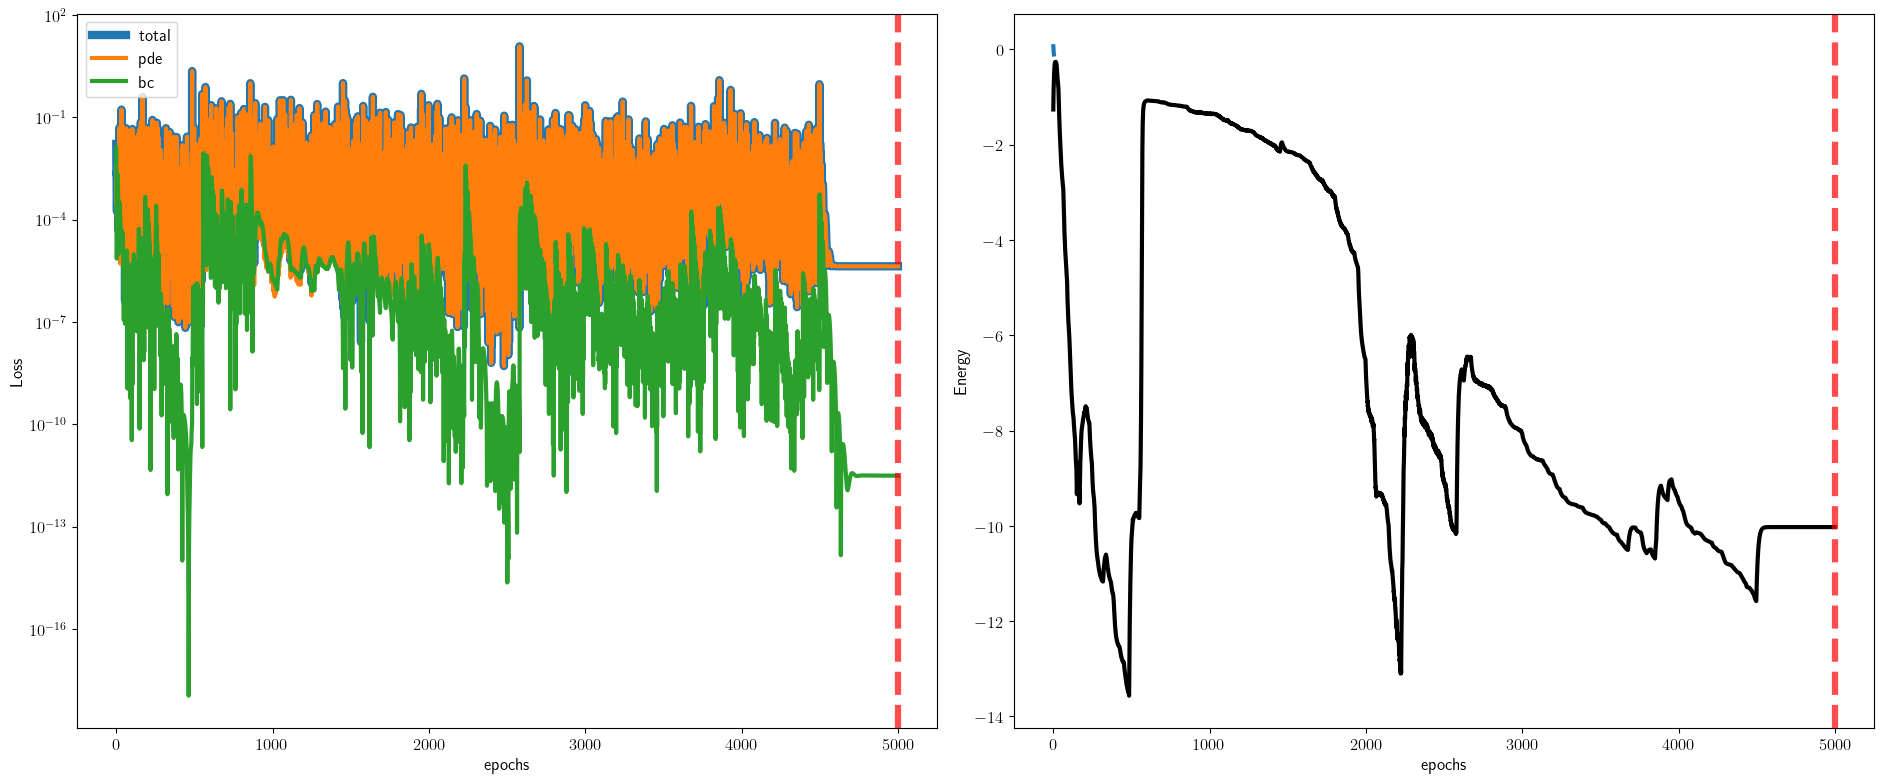

In [9]:
#### ----- Training: Single model ------------
train(params,loadWeights=False)

plotLoss(params,saveFig=False)

Rg, gate = returnGate()
plt.plot(Rg, gate, linewidth=lineW)

Train with Adam
Setup is 2 atoms with atomic numbers 8 and 8.
loading model
Freezeing Basis unit and Gate
2023-08-27 14:41:25
Min energy: tensor(-85.9874, grad_fn=<MinBackward1>) tensor(1)
epoch 100/2000
Estimate compute time (mins): 73.26615913709004
epoch 200/2000
epoch 300/2000
epoch 400/2000
epoch 500/2000
epoch 600/2000
epoch 700/2000
epoch 800/2000
epoch 900/2000
epoch 1000/2000
epoch 1100/2000
epoch 1200/2000
epoch 1300/2000
epoch 1400/2000
epoch 1500/2000
epoch 1600/2000
epoch 1700/2000
epoch 1800/2000
epoch 1900/2000
epoch 2000/2000
Optimal epoch:  1403
Runtime (min):  69.26525790294012
last learning rate:  [0.0005]


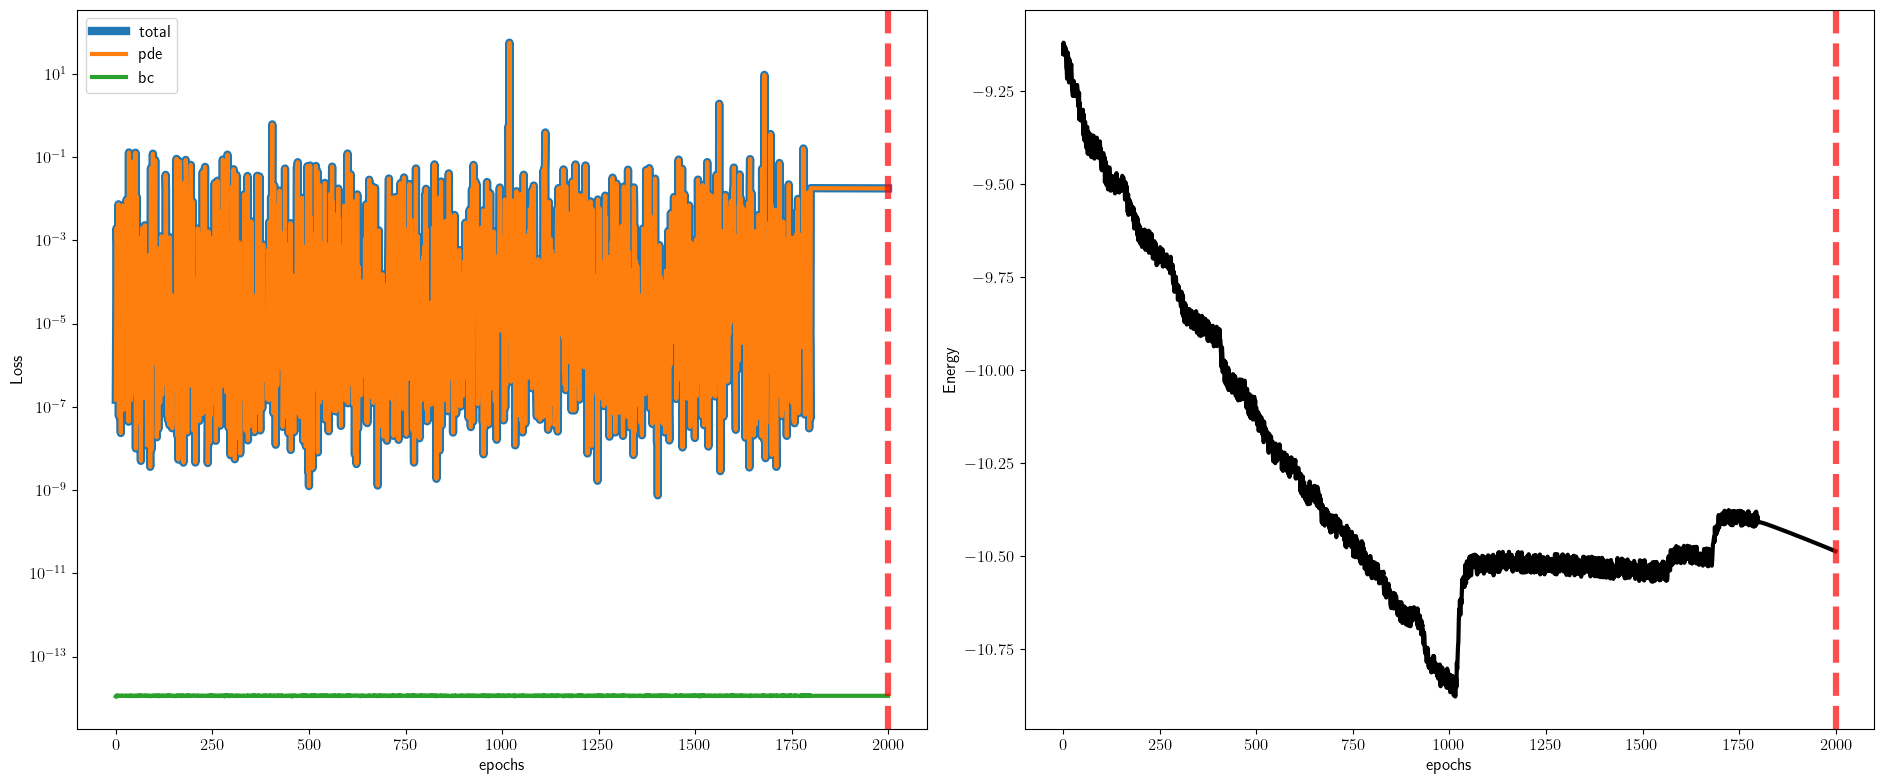

In [10]:
#### ----- Fine Tuning ----------

# params=set_params()
params['loadModelPath'] = "models/atoms_O2.pt"
params['lossPath'] = "data/loss_O2_fineTune.pkl"
params['EnergyPath'] = "data/energy_O2_fineTune.pkl" ; 
params['saveModelPath'] ="models/O2_fineTune.pt"

# params['sc_step'] = 10000; params['sc_decay']=.7
params['sc_sampling'] = 1

params['epochs'] = int(2e3)
nEpoch2 = params['epochs']
params['n_train'] = 10000 
params['lr'] = 5e-4;

train(params, loadWeights=True, freezeUnits=True); 

plotLoss(params, saveFig=False)

## HF

In [11]:
params = set_params()

params['epochs'] = int(5e3) 
nEpoch1 = params['epochs']
params['n_train'] = 10000
params['lr'] = 8e-3
params['Z1'] = 1
params['Z2'] = 9
params['num_orbitals'] = num_orbitals(params['Z1']) + num_orbitals(params['Z2'])
params['c_i'] = 0

params['lossPath'] = "data/loss_HF.pkl"
params['EnergyPath'] = "data/energy_HF.pkl" 
params['saveModelPath'] = "models/atoms_HF.pt"
params['loadModelPath'] = "models/atoms_HF.pt"
params['EnrR_path'] = "data/energy_R_HF.pkl"

Train with Adam
Setup is 2 atoms with atomic numbers 1 and 9.
2023-08-27 15:50:46
Min energy: tensor(-89.8703, grad_fn=<MinBackward1>) tensor(0)
epoch 100/5000
Estimate compute time (mins): 166.22495591640472
epoch 200/5000
epoch 300/5000
epoch 400/5000
epoch 500/5000
epoch 600/5000
epoch 700/5000
epoch 800/5000
epoch 900/5000
epoch 1000/5000
epoch 1100/5000
epoch 1200/5000
epoch 1300/5000
epoch 1400/5000
epoch 1500/5000
epoch 1600/5000
epoch 1700/5000
epoch 1800/5000
epoch 1900/5000
epoch 2000/5000
epoch 2100/5000
epoch 2200/5000
epoch 2300/5000
epoch 2400/5000
epoch 2500/5000
epoch 2600/5000
epoch 2700/5000
epoch 2800/5000
epoch 2900/5000
epoch 3000/5000
epoch 3100/5000
epoch 3200/5000
epoch 3300/5000
epoch 3400/5000
epoch 3500/5000
epoch 3600/5000
epoch 3700/5000
epoch 3800/5000
epoch 3900/5000
epoch 4000/5000
epoch 4100/5000
epoch 4200/5000
epoch 4300/5000
epoch 4400/5000
epoch 4500/5000
epoch 4600/5000
epoch 4700/5000
epoch 4800/5000
epoch 4900/5000
epoch 5000/5000
Optimal epoch: 

FileNotFoundError: [Errno 2] No such file or directory: 'models/atoms_HF.pt'

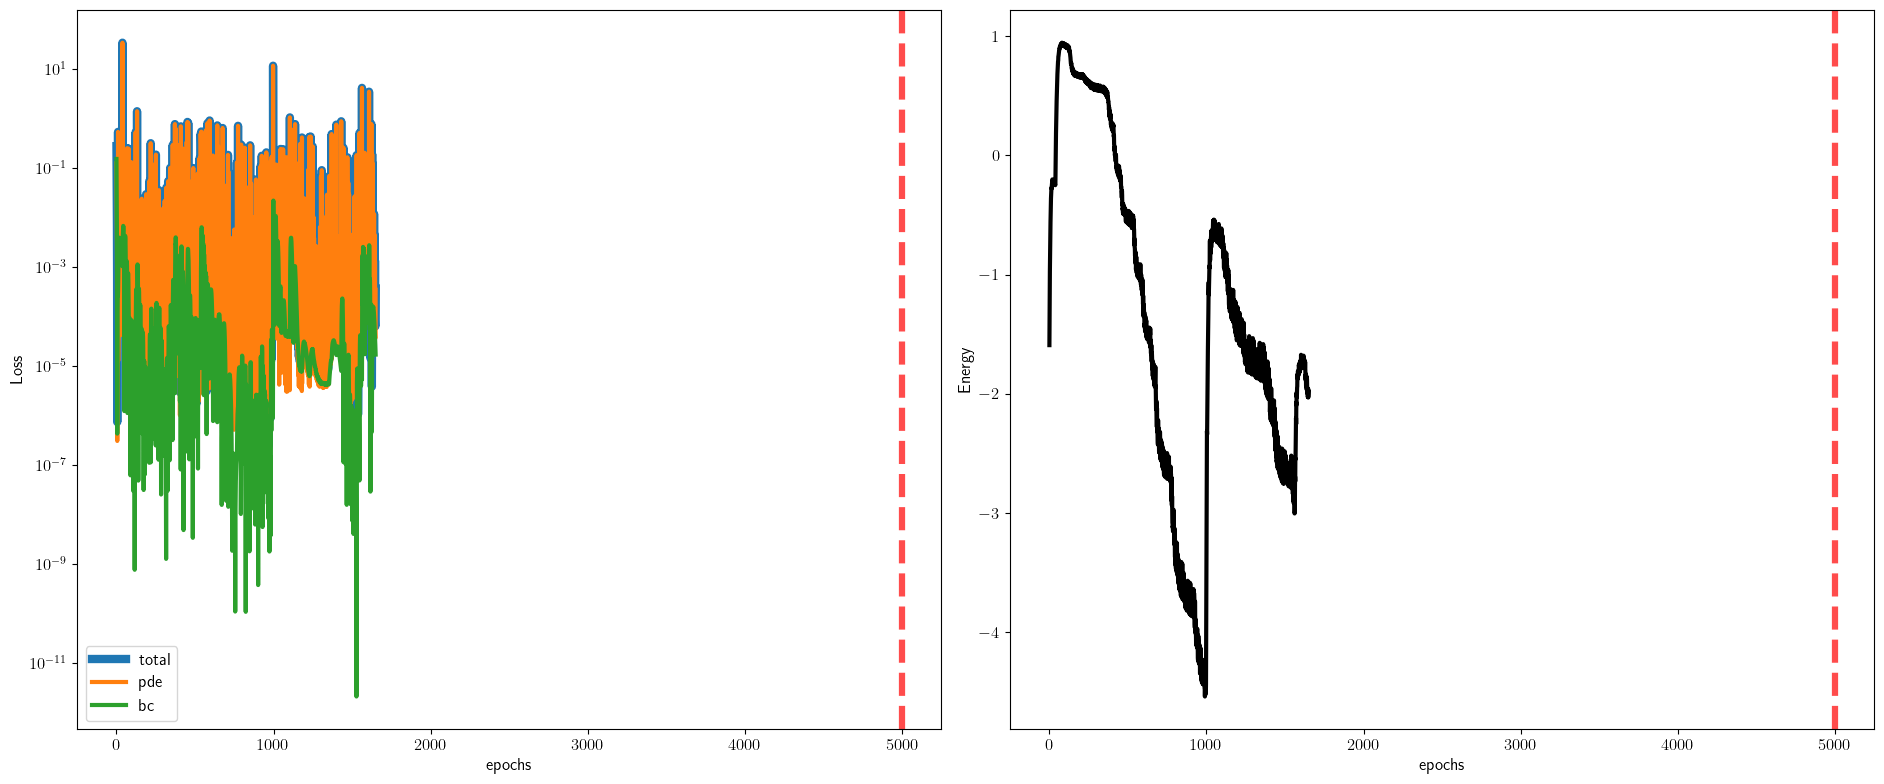

In [12]:
#### ----- Training: Single model ------------
train(params,loadWeights=False)

plotLoss(params,saveFig=False)

Rg, gate = returnGate()
plt.plot(Rg, gate, linewidth=lineW)

In [ ]:
#### ----- Fine Tuning ----------

# params=set_params()
params['loadModelPath'] = "models/atoms_HF.pt"
params['lossPath'] = "data/loss_HF_fineTune.pkl"
params['EnergyPath'] = "data/energy_HF_fineTune.pkl" ; 
params['saveModelPath'] ="models/HF_fineTune.pt"

# params['sc_step'] = 10000; params['sc_decay']=.7
params['sc_sampling'] = 1

params['epochs'] = int(2e3)
nEpoch2 = params['epochs']
params['n_train'] = 10000 
params['lr'] = 5e-4;

train(params, loadWeights=True, freezeUnits=True); 

plotLoss(params, saveFig=False)

Train with Adam
Setup is 2 atoms with atomic numbers 1 and 1.
epoch 100/5000
epoch 200/5000
epoch 300/5000
epoch 400/5000
epoch 500/5000
epoch 600/5000
epoch 700/5000
epoch 800/5000
epoch 900/5000
epoch 1000/5000
epoch 1100/5000
epoch 1200/5000
epoch 1300/5000
epoch 1400/5000
epoch 1500/5000
epoch 1600/5000
epoch 1700/5000
epoch 1800/5000
epoch 1900/5000
epoch 2000/5000
epoch 2100/5000
epoch 2200/5000
epoch 2300/5000
epoch 2400/5000
epoch 2500/5000
epoch 2600/5000
epoch 2700/5000
epoch 2800/5000
epoch 2900/5000
epoch 3000/5000
epoch 3100/5000
epoch 3200/5000
epoch 3300/5000
epoch 3400/5000
epoch 3500/5000
epoch 3600/5000
epoch 3700/5000
epoch 3800/5000
epoch 3900/5000
epoch 4000/5000
epoch 4100/5000
epoch 4200/5000
epoch 4300/5000
epoch 4400/5000
epoch 4500/5000
epoch 4600/5000
epoch 4700/5000
epoch 4800/5000
epoch 4900/5000
epoch 5000/5000
Optimal epoch:  3303
Runtime (min):  522.4812629143397
last learning rate:  [0.008]


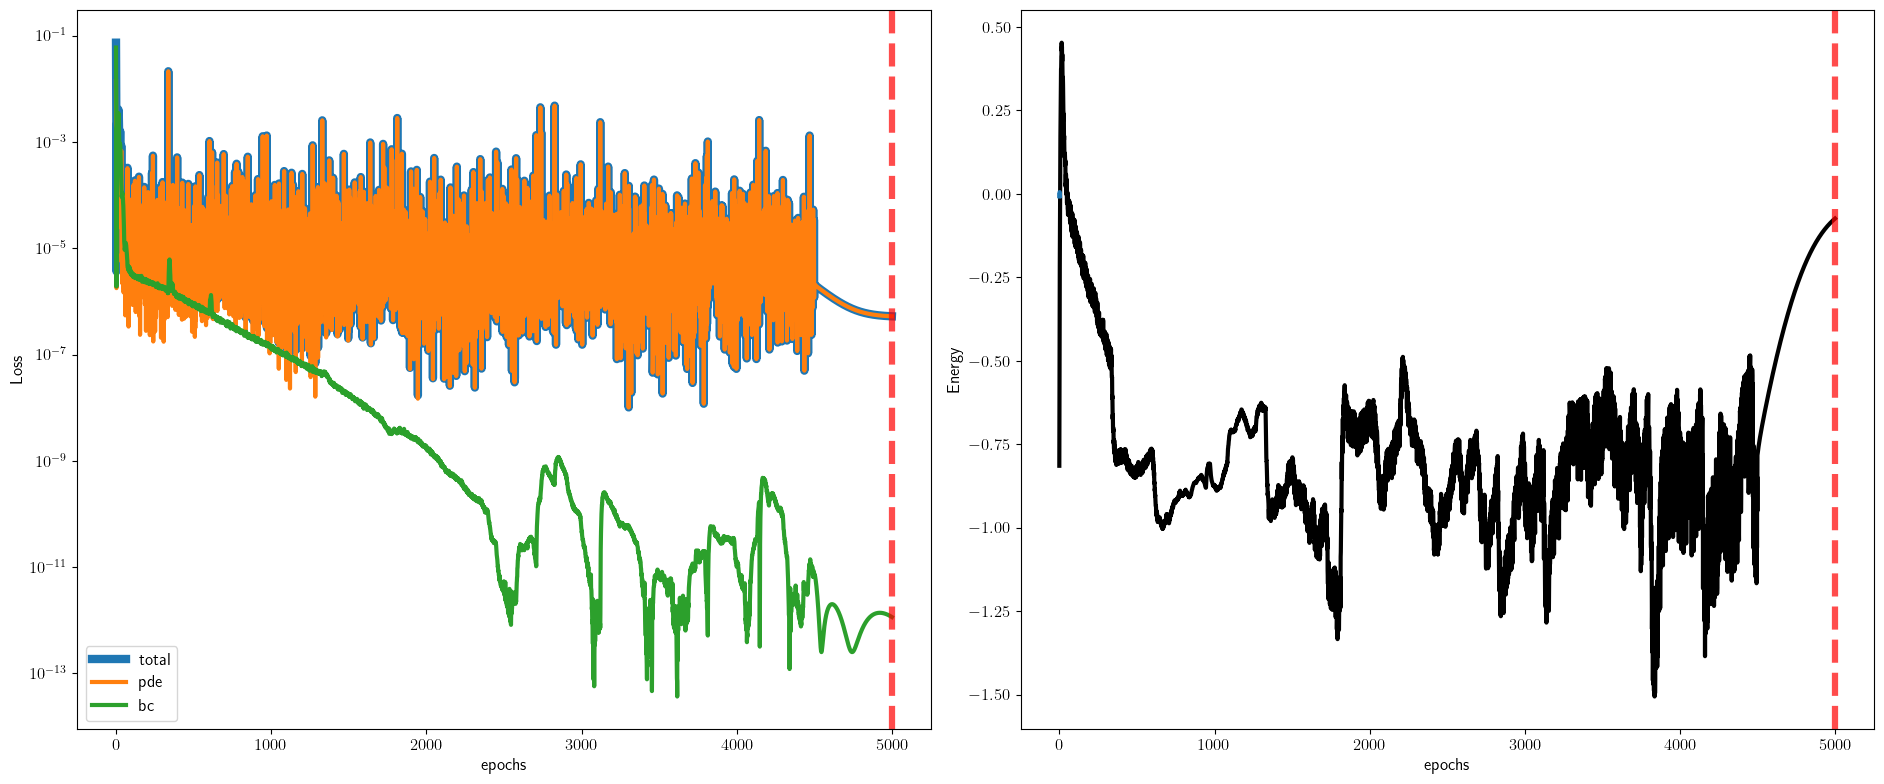

In [9]:
model = NN_atom(params)

#### ----- Training: Single model ------------
print(time.time())
train(params,loadWeights=False)

plotLoss(params,saveFig=False)

Rg, gate = returnGate()
plt.plot(Rg, gate, linewidth=lineW)

In [14]:
params['saveModelPath'] ="models/atomsym.pt"
model.saveModel(params,optimizer=torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=0))

In [9]:
#### ----- Fine Tuning ----------

# params=set_params()
params['loadModelPath'] = "models/atomsym.pt"
params['lossPath'] = "data/loss_atom_fineTune.pkl" ; 
params['EnergyPath'] = "data/energy_atom_fineTune.pkl" ; 
params['saveModelPath'] ="models/atom_fineTune.pt"

# params['sc_step'] = 10000; params['sc_decay']=.7
params['sc_sampling'] = 1

params['epochs'] = int(2e3); nEpoch2 = params['epochs']
params['n_train'] = 100000 
params['lr'] = 5e-4;

train(params, loadWeights=True, freezeUnits=True); 

plotLoss(params, saveFig=False)

Train with Adam
Setup is 2 atoms with atomic numbers 1 and 1.
loading model
Freezeing Basis unit and Gate


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 16.66 GiB already allocated; 0 bytes free; 21.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## How is the training time affected by the atom size (and number of electrons)

In [28]:
#setting some parameters
params = set_params()
nEpoch1 = params['epochs']
nEpoch2 = params['epochs']
params['n_train'] = 100000

#list of diatomic molecules
atom_list = ['h2','He2','Li2','Be2','B2','C2','N2','O2','F2']
training_time_list = []
fine_tune_time_list = []

In [29]:
for Z in range(1,10):
    params['Z'] = Z
    params['N_electrons'] = 2*params['Z']
    params['epochs'] = int(5e3)
    params['lr'] = 8e-3
    
    train_time = train(params,loadWeights=False)
    training_time_list.append(train_time)
    
    Rg, gate = returnGate()
    
    params['loadModelPath'] = "models/atomsym.pt"
    params['lossPath'] = "data/loss_atom_fineTune.pkl" ; 
    params['EnergyPath'] = "data/energy_atom_fineTune.pkl" ; 
    params['saveModelPath'] ="models/atom_fineTune.pt"

    #params['sc_step'] = 10000; params['sc_decay']=.7
    params['sc_sampling'] = 1

    params['epochs'] = int(2e3)
    params['lr'] = 5e-4;

    fine_tune_time = train(params,loadWeights=True,freezeUnits=True)
    fine_tune_time_list.append(fine_tune_time)

Train with Adam
Setup is 2 atoms with atomic number 1.
epoch 100/5000
epoch 200/5000
epoch 300/5000
epoch 400/5000
epoch 500/5000
epoch 600/5000
epoch 700/5000
epoch 800/5000
epoch 900/5000
epoch 1000/5000
epoch 1100/5000


KeyboardInterrupt: 

In [ ]:
plt.plot(atom_list,training_time_list)
plt.xlabel('Atoms')
plt.ylabels('Train time (s)')
plt.show()

plt.plot(atom_list,fine_tune_time_list)
plt.xlabel('Atoms')
plt.ylabels('Fine tune train time (s)')
plt.show()